# Calculs des Rayons de Robustesse Optimistes et Pessimistes avec Torch

In [1]:
import torch
from torchvision import datasets, transforms
from deel import torchlip
import numpy as np
import foolbox as fb

In [2]:
train_set = datasets.FashionMNIST(
    root="./data",
    download=True,
    train=True,
    transform=transforms.ToTensor(),
)

test_set = datasets.FashionMNIST(
    root="./data",
    download=True,
    train=False,
    transform=transforms.ToTensor(),
)

batch_size = 100
train_loader = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size)


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
model = torch.load('/home/aws_install/robustess_project/lip_models/torch_FMNIST.pth', weights_only=False)

In [5]:
# Select only the first batch from the test set
sub_data, sub_targets = next(iter(test_loader))
sub_data, sub_targets = sub_data.to(device), sub_targets.to(device)

# Drop misclassified elements
output = model(sub_data)
well_classified_mask = output.argmax(dim=-1) == sub_targets
sub_data = sub_data[well_classified_mask]
sub_targets = sub_targets[well_classified_mask]

# Retrieve one image per class
images_list, targets_list = [], []
for i in range(10):
    # Select the elements of the i-th label and keep the first one
    label_mask = sub_targets == i
    x = sub_data[label_mask][0]
    y = sub_targets[label_mask][0]

    images_list.append(x)
    targets_list.append(y)

images = torch.stack(images_list)
targets = torch.stack(targets_list)


In [6]:
images.shape

torch.Size([10, 1, 28, 28])

In order to build a certificate $\mathcal{M}$ for a given sample, we take the top-2
output and apply the following formula:

$$ \mathcal{M} = \frac{\text{top}_1 - \text{top}_2}{2} $$

This certificate is a guarantee that no L2 attack can defeat the given image sample with
a robustness radius $\epsilon$ lower than the certificate, i.e.

$$ \epsilon \geq \mathcal{M} $$

In the following cell, we attack the model on the ten selected images and compare the
obtained radius $\epsilon$ with the certificates $\mathcal{M}$. In this setup,
`L2CarliniWagnerAttack` from `foolbox` is used but in practice as these kind of networks
are gradient norm preserving, other attacks gives very similar results.


## Attacks with Foolbox

In [7]:
# Compute certificates
values, _ = model(images).topk(k=2)
#The factor is 2.0 when using disjoint_neurons==True
certificates = (values[:, 0] - values[:, 1]) / 2. 

# Run Carlini & Wagner attack
fmodel = fb.PyTorchModel(model, bounds=(0.0, 1.0), device=device)
attack = fb.attacks.L2CarliniWagnerAttack(binary_search_steps=6, steps=8000)
_, advs, success = attack(fmodel, images, targets, epsilons=None)
dist_to_adv = (images - advs).square().sum(dim=(1, 2, 3)).sqrt()

# Print results
print("Image #     Certificate     Distance to adversarial")
print("---------------------------------------------------")
for i in range(len(certificates)):
    print(f"Image {i}        {certificates[i]:.3f}                {dist_to_adv[i]:.2f}")


Image #     Certificate     Distance to adversarial
---------------------------------------------------
Image 0        0.321                1.21
Image 1        1.838                4.38
Image 2        0.487                1.79
Image 3        0.624                1.99
Image 4        0.140                0.50
Image 5        0.297                1.07
Image 6        0.031                0.14
Image 7        0.428                1.54
Image 8        1.569                4.17
Image 9        0.247                1.06


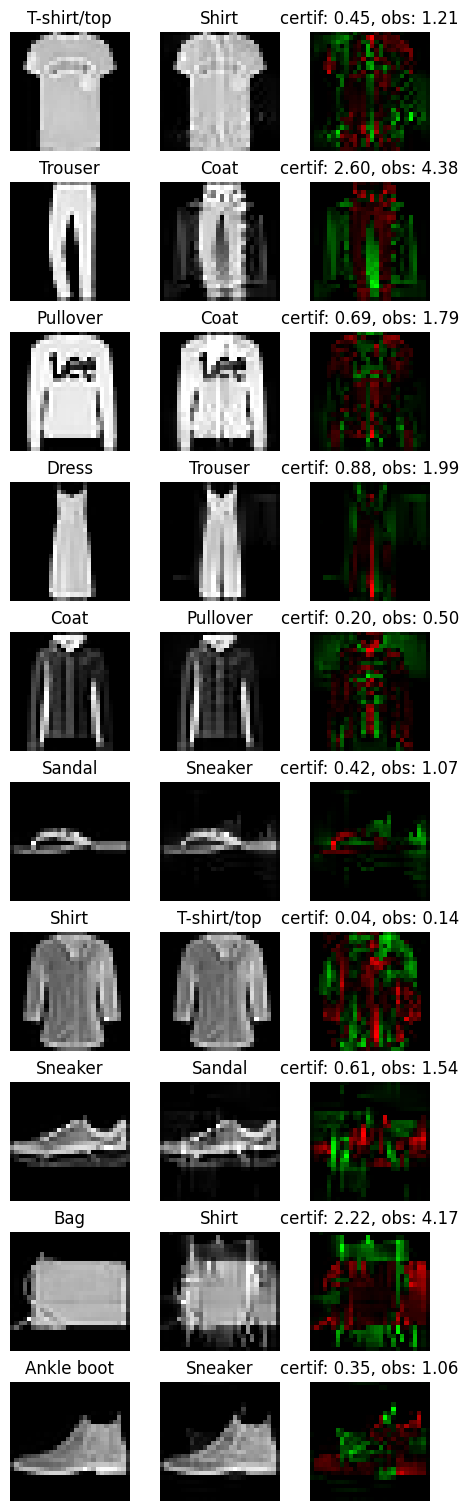

In [8]:
import matplotlib.pyplot as plt

def adversarial_viz(model, images, advs, class_names):
    """
    This functions shows for each image sample:
    - the original image
    - the adversarial image
    - the difference map
    - the certificate and the observed distance to adversarial
    """
    scale = 1.5
    nb_imgs = images.shape[0]

    # Compute certificates
    values, _ = model(images).topk(k=2)
    certificates = (values[:, 0] - values[:, 1]) / np.sqrt(2)

    # Compute distance between image and its adversarial
    dist_to_adv = (images - advs).square().sum(dim=(1, 2, 3)).sqrt()

    # Find predicted classes for images and their adversarials
    orig_classes = [class_names[i] for i in model(images).argmax(dim=-1)]
    advs_classes = [class_names[i] for i in model(advs).argmax(dim=-1)]

    # Compute difference maps
    advs = advs.detach().cpu()
    images = images.detach().cpu()
    diff_pos = np.clip(advs - images, 0, 1.0)
    diff_neg = np.clip(images - advs, 0, 1.0)
    diff_map = np.concatenate(
        [diff_neg, diff_pos, np.zeros_like(diff_neg)], axis=1
    ).transpose((0, 2, 3, 1))

    # Create plot
    def _set_ax(ax, title):
        ax.set_title(title)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.axis("off")

    figsize = (3 * scale, nb_imgs * scale)
    _, axes = plt.subplots(
        ncols=3, nrows=nb_imgs, figsize=figsize, squeeze=False, constrained_layout=True
    )
    for i in range(nb_imgs):
        _set_ax(axes[i][0], orig_classes[i])
        axes[i][0].imshow(images[i].squeeze(), cmap="gray")
        _set_ax(axes[i][1], advs_classes[i])
        axes[i][1].imshow(advs[i].squeeze(), cmap="gray")
        _set_ax(axes[i][2], f"certif: {certificates[i]:.2f}, obs: {dist_to_adv[i]:.2f}")
        axes[i][2].imshow(diff_map[i] / diff_map[i].max())


adversarial_viz(model, images, advs, test_set.classes)

## Attacks With AutoAttacks

### torchattacks

In [9]:
import torchattacks
from robustbench.utils import clean_accuracy

/home/aws_install/miniconda3/envs/k3torchenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
images.shape

torch.Size([10, 1, 28, 28])

In [11]:
atk = torchattacks.AutoAttack(model, norm='L2', eps=1)

In [12]:
adv_images = atk(images, targets)

In [13]:
acc = clean_accuracy(model, adv_images, targets)

In [14]:
dist_to_adv = (images - adv_images).square().sum(dim=(1, 2, 3)).sqrt()

In [15]:
acc

0.8

In [ ]:
# Print results
print("Image #     Certificate     Distance to adversarial")
print("---------------------------------------------------")
for i in range(len(certificates)):
    print(f"Image {i}        {certificates[i]:.3f}                {dist_to_adv[i]:.2f}")


Image #     Certificate     Distance to adversarial
---------------------------------------------------
Image 0        0.321                0.00
Image 1        1.838                0.00
Image 2        0.487                0.00
Image 3        0.624                0.00
Image 4        0.140                0.99
Image 5        0.297                0.00
Image 6        0.031                0.99
Image 7        0.428                0.00
Image 8        1.569                0.00
Image 9        0.247                0.00


In [17]:
from tqdm import tqdm

In [18]:
def single_compute_optimistic_radius(image, target, certificate):

    # we find a multiple of the certificate such as we find an adversarial attack
    final_eps = []
    optimistic_radius = 0
    k=0
    while (optimistic_radius == 0):
        k = k+1
        atk = torchattacks.AutoAttack(model, norm='L2', eps=k*certificate)
        adv_image = atk(image, target)
        optimistic_radius = (image - adv_image).square().sum(dim=(1, 2, 3)).sqrt()
    print("We found an adversarial attack for eps=", k*certificate)
    # We use dichotomy algorithm to fine the smallest optimistic radius
    print("Launching Dichotomy :")
    eps = (k*certificate)/2
    print(eps)
    final_eps.append(eps)
    for _ in range(10):
        atk = torchattacks.AutoAttack(model, norm='L2', eps=eps)
        adv_image = atk(image, target)
        optimistic_radius = (image - adv_image).square().sum(dim=(1, 2, 3)).sqrt()
        if optimistic_radius == 0:
            print(eps, " not ok")
            eps = eps * 3/2
        else:
            print(eps, " ok")
            final_eps.append(eps)
            eps = eps/2 
    return min(final_eps)


In [19]:
# single_compute_optimistic_radius(images[:1], targets[:1], certificates[:1])

/tmp/ipykernel_16783/2172850485.py:51: RuntimeWarning: invalid value encountered in divide
  axes[i][2].imshow(diff_map[i] / diff_map[i].max())


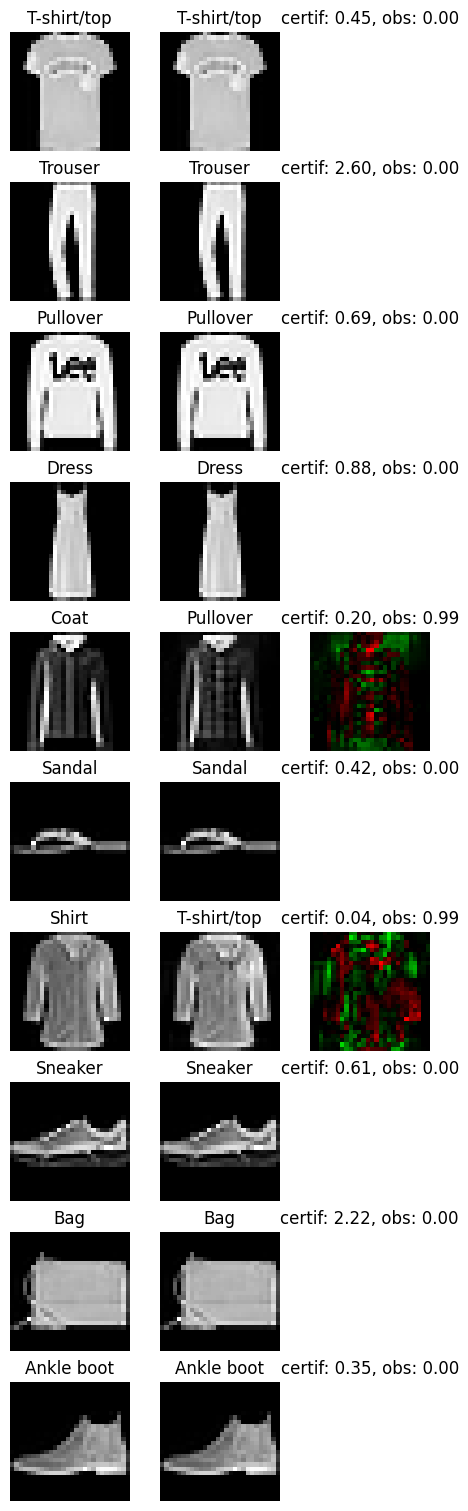

In [20]:
adversarial_viz(model, images, adv_images, test_set.classes)

TODO : faire une fonction qui pour chaque point applique AutoAttack avec epsilon variable (dichotomie)

### autoattack

In [21]:
from autoattack import AutoAttack

In [22]:
atk = AutoAttack(model, norm='L2', eps=2, version='standard')

setting parameters for standard version


In [23]:
adv_images = atk.run_standard_evaluation(images, targets, bs=len(images)).cuda()

using standard version including apgd-ce, apgd-t, fab-t, square.
initial accuracy: 100.00%


apgd-ce - 1/1 - 5 out of 10 successfully perturbed
robust accuracy after APGD-CE: 50.00% (total time 0.4 s)
apgd-t - 1/1 - 2 out of 5 successfully perturbed
robust accuracy after APGD-T: 30.00% (total time 4.2 s)
fab-t - 1/1 - 0 out of 3 successfully perturbed
robust accuracy after FAB-T: 30.00% (total time 11.4 s)


KeyboardInterrupt: 

In [ ]:
dist_to_adv = (images - adv_images).square().sum(dim=(1, 2, 3)).sqrt()

In [ ]:
# Print results
print("Image #     Certificate     Distance to adversarial")
print("---------------------------------------------------")
for i in range(len(certificates)):
    print(f"Image {i}        {certificates[i]:.3f}                {dist_to_adv[i]:.2f}")


Image #     Certificate     Distance to adversarial
---------------------------------------------------
Image 0        0.321                2.00
Image 1        1.838                0.00
Image 2        0.487                1.99
Image 3        0.624                0.00
Image 4        0.140                2.00
Image 5        0.297                2.00
Image 6        0.031                2.00
Image 7        0.428                2.00
Image 8        1.569                0.00
Image 9        0.247                2.00
